In [ ]:
# Importing Keras
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit

# Importing TensorFlow
import tensorflow as tf

# Importing utils
import random
import plotly.subplots as sp
import plotly.graph_objs as go
import os
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import plotly.subplots as sp
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, train_test_split
import matplotlib
import time

import matplotlib.pyplot as plt
import matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuring notebook
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'

In [ ]:
def image_resizer(paths):
    """
    This function resizes the input images
    """
    with ThreadPoolExecutor() as executor:
        resized_images = list(executor.map(lambda x: Image.open(x).resize((350,250)), paths))
    return resized_images

def plot_images_list(images, title, subtitle):
    '''
    This functions helps to plot a matrix of images in a list
    '''
    fig = sp.make_subplots(rows=3, cols=3)
    images = image_resizer(images)

    traces = []
    for i in range(min(9, len(images))):
        img = go.Image(z=images[i])
        traces.append((img, i//3+1, i%3+1))

    fig.add_traces([trace[0] for trace in traces],
                  rows = [trace[1] for trace in traces],
                  cols = [trace[2] for trace in traces])

    fig.update_layout(
        title={'text': f'<b>{title}<br>  <i><sub>{subtitle}</sub></i></b>',
               'font': dict(size = 22)},
        height=800,
        width=800,
        margin=dict(t=110, l=80),
        plot_bgcolor=bg_color,paper_bgcolor=paper_color
        #template=template
    )
    fig.show()

In [ ]:
# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print('\nGPU Found! Using GPU...')
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)


GPU Found! Using GPU...


In [ ]:
# Imposta il percorso della directory contenente i tuoi dataset di addestramento e test
train_dir = '/content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Training'
test_dir = '/content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing'


# Giving names to each directory
directories = {
    train_dir: 'Training',
    test_dir: 'Test',
    }

# Naming subfolders
subfolders = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total of pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)



* * * * * Number of files in each folder * * * * *


Training/glioma_tumor: 802

Training/meningioma_tumor: 707

Training/no_tumor: 246

Training/pituitary_tumor: 798

  Total: 2553
--------------------------------------------------------------------------------

Test/glioma_tumor: 84

Test/meningioma_tumor: 113

Test/no_tumor: 81

Test/pituitary_tumor: 36

  Total: 314
--------------------------------------------------------------------------------


In [ ]:
# Definisci le dimensioni a cui vuoi ridimensionare le immagini
target_size = (224, 224)

# Funzione per caricare e ridimensionare le immagini con sottocartelle come etichette
def load_and_resize_images(directory, target_size):
    images = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, target_size)
                img = img / 255.0  # Normalizza i valori dei pixel
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

# Carica e ridimensiona il dataset di addestramento
X_train, y_train = load_and_resize_images(train_dir, target_size)

# Carica e ridimensiona il dataset di test
X_test, y_test = load_and_resize_images(test_dir, target_size)

# Unisci i dataset di addestramento e test
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# One-hot encode delle etichette
encoder = OneHotEncoder(sparse_output=False)
y_combined_onehot = encoder.fit_transform(y_combined.reshape(-1, 1))
y_train_onehot = encoder.transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Fai lo shuffle dei dati combinati
X_combined_shuffled, y_combined_shuffled = shuffle(X_combined, y_combined_onehot, random_state=42)

# Suddividi i dati in set di addestramento (80%) e test (20%)
train_inputs, test_inputs, train_targets, test_targets = train_test_split(X_combined_shuffled, y_combined_shuffled, test_size=0.2, random_state=42)


In [ ]:
print("Dimensioni di X_val:", train_inputs.shape)
print("Dimensioni di X_test:", train_targets.shape, "\n")
print("Dimensioni di y_val:", test_inputs.shape)
print("Dimensioni di y_test:", test_targets.shape)

Dimensioni di X_val: (2293, 224, 224)
Dimensioni di X_test: (2293, 4) 

Dimensioni di y_val: (574, 224, 224)
Dimensioni di y_test: (574, 4)


In [ ]:
#Model
batch_size = 32

# Initiating model on GPU
with strategy.scope():

    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (224,224,1)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = "softmax"))

In [ ]:
#Elapsed Time
start_time = time.time()

# Compiling model
model.compile(optimizer = tf.keras.optimizers.Adam(), # 1e-2
              loss = 'categorical_crossentropy',  # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric



# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                                patience = 5, mode = 'max',
                                restore_best_weights = True)

checkpoint = ModelCheckpoint('fusion_weghts.h5',
                              monitor = 'val_accuracy',
                              save_best_only = True)

print('\nI-esimo giro\n')

# Training and Testing Model
try:
    history = model.fit(
                        train_inputs,
                        train_targets,
                        epochs=50,
                        validation_split=0.2,
                        callbacks=[early_stopping, checkpoint],
                        batch_size=batch_size
                      )
except Exception as e:
    print("An error occurred:", e)

end_time = time.time()
interval = end_time - start_time
print(f"Training phase Elapsed Time: {interval} seconds")


I-esimo giro

Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 1.2631 - accuracy: 0.4215

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 20s 303ms/step - loss: 1.2631 - accuracy: 0.4215 - val_loss: 1.0506 - val_accuracy: 0.5054
Epoch 2/50
58/58 [==============================] - 12s 209ms/step - loss: 1.0353 - accuracy: 0.5600 - val_loss: 1.0579 - val_accuracy: 0.5316
Epoch 3/50
58/58 [==============================] - 15s 262ms/step - loss: 0.8877 - accuracy: 0.6254 - val_loss: 0.8379 - val_accuracy: 0.6187
Epoch 4/50
58/58 [==============================] - 10s 170ms/step - loss: 0.7588 - accuracy: 0.6930 - val_loss: 0.9361 - val_accuracy: 0.5839
Epoch 5/50
58/58 [==============================] - 10s 168ms/step - loss: 0.7076 - accuracy: 0.7148 - val_loss: 0.8248 - val_accuracy: 0.6100
Epoch 6/50
58/58 [==============================] - 15s 268ms/step - loss: 0.6351 - accuracy: 0.7426 - val_loss: 0.7716 - val_accuracy: 0.6776
Epoch 7/50
58/58 [==============================] - 14s 242ms/step - loss: 0.6151 - accuracy: 0.7579 - val_loss: 0.7116 - val_accuracy: 0.6841
Epoch 8/50

In [ ]:
# Creating subplot
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# Loss over epochs
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray over epochs
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Validation',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

# Updating layout
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color,
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

# Showing figure
fig.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 128)       0

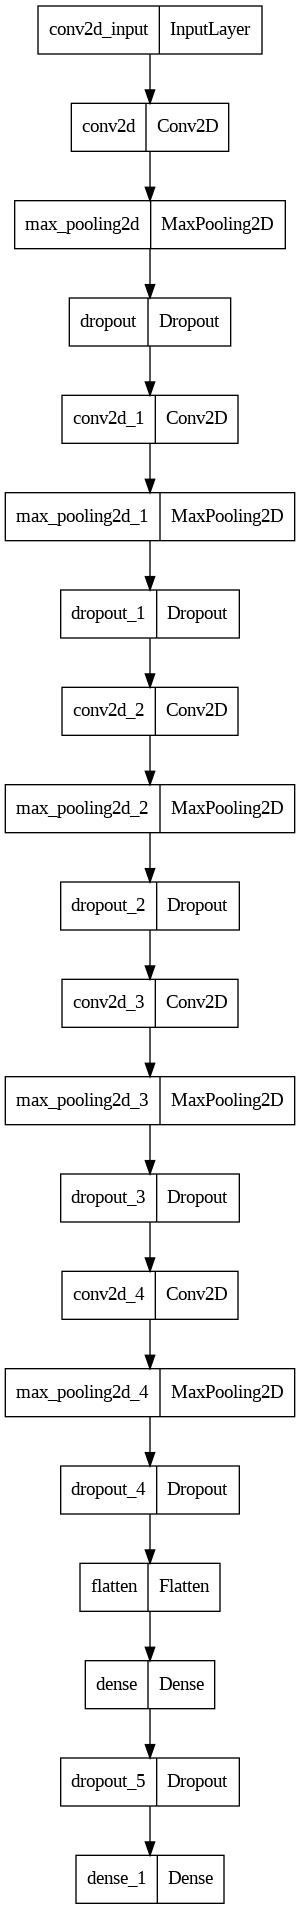

In [ ]:
# Model summary
model.summary() # Printing model summary
tf.keras.utils.plot_model(model) # Plotting model

In [ ]:
# Loading best weights
model.load_weights('/content/fusion_weghts.h5')

In [ ]:
preds =model.predict(test_inputs, batch_size=batch_size)  # Running model on the test dataset
test_loss, test_acc = model.evaluate(test_inputs, test_targets) # Obtaining Loss and Accuracy on the test dataset

print('\nTest Loss: ', test_loss)
print('\nTest Accuracy: ', np.round(test_acc * 100), '%')


18/18 [==============================] - 1s 27ms/step - loss: 0.4018 - accuracy: 0.8728

Test Loss:  0.40180113911628723

Test Accuracy:  87.0 %


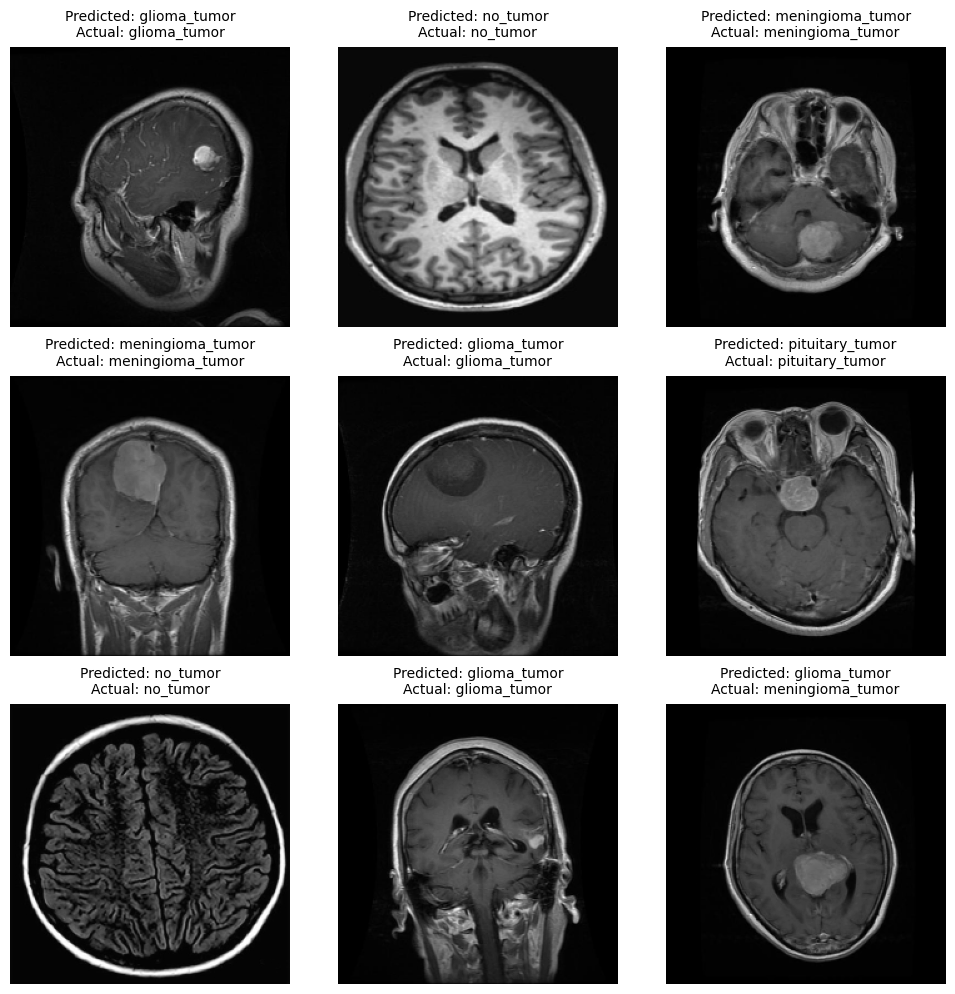

In [ ]:
y_pred_classes = np.argmax(preds, axis=1)
y_true_classes = np.argmax(test_targets, axis=1)
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Filtra le prime 9 immagini
num_images_to_display = 9
indices_to_display = np.random.choice(len(test_inputs), num_images_to_display, replace=False)

# Crea il grafico 3x3
plt.figure(figsize=(10, 10))
for i, index in enumerate(indices_to_display, 1):
    plt.subplot(3, 3, i)
    plt.imshow(test_inputs[index], cmap='gray')
    predicted_label = labels[y_pred_classes[index]]
    true_label = labels[y_true_classes[index]]
    plt.text(0.5, 1.08, f'Predicted: {predicted_label}\nActual: {true_label}',
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=plt.gca().transAxes)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Saving model
model.save('fusion_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

